In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.atomic.features as fs
#import socceraction.atomic.labels as lab

In [2]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]

380it [00:08, 42.46it/s]


game_id  period_id  action_id  time_seconds     timestamp  team_id  \
0  14562.0        1.0          0           1.0  00:00:01.344     58.0   
1  14562.0        1.0          1           1.5  00:00:02.117     58.0   
2  14562.0        1.0          2           2.0  00:00:02.117     58.0   
3  14562.0        1.0          3           2.0  00:00:02.969     58.0   
4  14562.0        1.0          4           3.0  00:00:04.338     58.0   

   player_id          x          y         dx         dy  type_id  \
0     9923.0  52.058824  34.430380 -10.588235  -0.000000        0   
1     9917.0  41.470588  34.430380  -0.000000  -0.000000       23   
2     9917.0  41.470588  34.430380  -0.000000  -0.000000       21   
3     9917.0  41.470588  34.430380 -15.882353 -14.632911        0   
4     9924.0  25.588235  19.797468  -0.000000  -0.000000       23   

   bodypart_id type_name  
0            0      pass  
1            0  receival  
2            0   dribble  
3            0      pass  
4            0  receival

In [5]:
from scipy.spatial import Delaunay
import networkx as nx

def color_clusters(clusters,colors):
    tri = Delaunay(clusters)
    edges = set()
    for s in tri.simplices:
        [a,b,c] = s
        es = set([frozenset([a,b]),frozenset([b,c]),frozenset([c,a])])
        edges = edges | es
    G = nx.Graph()
    for e in edges:
        [i,j] = list(e)
        G.add_edge(i, j)
    
    if len(G.nodes) > 0:
        r_ = max([G.degree(node) for node in G.nodes])
    else:
        r_ = 0
    if r_ > len(colors)-1:
        colorassign = nx.algorithms.coloring.greedy_color(G)
    else:
        colorassign = nx.algorithms.coloring.equitable_color(G,len(colors))
    colorvector = [0] * len(clusters)
    for k,v in colorassign.items():
        colorvector[k] = int(v)
    return [colors[i] for i in colorvector]

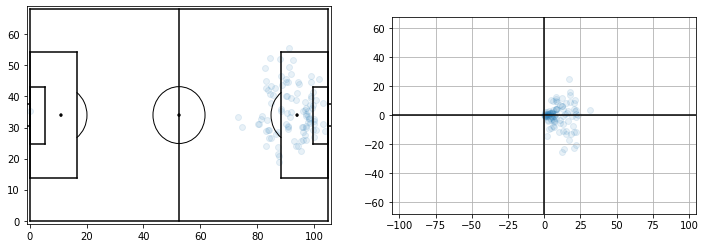

In [7]:
import matplotsoccer as mps
import matplotlib.pyplot as plt

a = actions[actions.type_name == "shot"][:100]


def plot_deltas(x,y,dx,dy,color,):
    fig,axs = plt.subplots(1,2)
    fig.set_size_inches((12,4))
    axs[0].scatter(x,y,color=color,alpha=0.1)
    axs[1].scatter(dx,dy,color=color,alpha=0.1)
    mps.field(ax=axs[0],show=False)
    plt.axis("on")
    plt.axis("scaled")
    axs[1].axvline(0,color="black")
    axs[1].axhline(0,color="black")
    axs[1].grid()
    axs[0].set_xlim(-1,105+1)
    axs[0].set_ylim(-1,68+1)
    #axs[1].set_xlim(-1.1,1.1)
    #axs[1].set_ylim(-1.1,1.1)
    axs[1].set_xlim(-105,105)
    axs[1].set_ylim(-68,68)
    plt.show()
    
def prepare_axes():
    fig,axs = plt.subplots(1,2)
    fig.set_size_inches((12,4))
    mps.field(ax=axs[0],show=False)
    plt.axis("on")
    plt.axis("scaled")
    axs[1].axvline(0,color="black")
    axs[1].axhline(0,color="black")
    axs[1].grid()
    axs[0].set_xlim(-1,105+1)
    axs[0].set_ylim(-1,68+1)
    #axs[1].set_xlim(-1.1,1.1)
    #axs[1].set_ylim(-1.1,1.1)
    axs[1].set_xlim(-105,105)
    axs[1].set_ylim(-68,68)
    return axs

#plot_deltas(a.x,a.y,a.dx,a.dy,color="blue")
axs = prepare_axes()
axs[0].scatter(a.x,a.y,alpha=0.1)
axs[1].scatter(a.dx,a.dy,alpha=0.1)
plt.show()

In [8]:
# Make a nice action subset
a = actions[:200000].fillna(0)
corner_idx = a.type_name.str.contains("corner")
a["type_name"] = a["type_name"].mask(corner_idx,"corner")

freekick_idx = a.type_name.str.contains("freekick")
a["type_name"] = a["type_name"].mask(freekick_idx,"freekick")

keeper_idx = a.type_name.str.contains("keeper")
a["type_name"] = a["type_name"].mask(keeper_idx,"keeper_catch")

a["x"] = a.x.mask(a.type_name=="goalkick",5)
a["y"] = a.y.mask(a.type_name=="goalkick",32.5)

In [71]:
import sklearn.mixture as mix


def bootstrap(actions):
    models = {}
    for k, df in actions.groupby("type_name"):
        if len(df) > 50:
            model = {}
            model["df"] = df
            model["cols"] = [#"x","y",
                             "dx","dy"]
            a = model["df"][model["cols"]]
            model["base"] = mix.GaussianMixture(1).fit(a)
            model["base_bic"] = model["base"].bic(a)
            model["cand"] = mix.GaussianMixture(2).fit(a)
            model["cand_bic"] = model["cand"].bic(a)
            models[k] = model
    return models

models = bootstrap(a)

/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_ite

In [75]:
def get_improvs(models):
    improvs = [(m["cand_bic"] - m["base_bic"], 
                k,
                m["cand"].n_components - m["base"].n_components)
              for k,m in models.items()]
    return sorted(improvs)

def get_n_components(models):
    return sum(m["base"].n_components for m in models.values())

def accept_cand(model):
    model["base"],model["base_bic"] = model["cand"],model["cand_bic"]
    return model
    
def new_cand(model):
    n = model["cand"].n_components
    a = model["df"][model["cols"]]
    model["cand"] = mix.GaussianMixture(n+1).fit(a)
    model["cand_bic"] = model["cand"].bic(a)
    return model

while get_n_components(models) < 80:
    improvs = get_improvs(models)
    bic_delta,k,n_delta = improvs[0]
    if bic_delta < 0:
        accept_cand(models[k])
        print(improvs[0],get_n_components(models))
    new_cand(models[k])

(-43.54467478062543, 'corner', 2) 52


/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_ite

(-302.23842555406736, 'dribble', 2) 54


/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)


(-93.23000468499231, 'throw_in', 3) 57
(-246.32080982669868, 'throw_in', 1) 58
(-45.66344741266221, 'throw_in', 1) 59


/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_ite

/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_ite

/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return_n_i

/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return_n_

KeyboardInterrupt: 

In [76]:
{k: m["base"].n_components for k,m in models.items()}
#get_improvs(models)
#get_n_components(models)

{'bad_touch': 1,
 'clearance': 4,
 'corner': 7,
 'cross': 6,
 'dribble': 7,
 'foul': 1,
 'freekick': 3,
 'goal': 1,
 'goalkick': 7,
 'interception': 1,
 'keeper_catch': 1,
 'offside': 1,
 'out': 1,
 'pass': 2,
 'receival': 1,
 'shot': 5,
 'tackle': 1,
 'take_on': 1,
 'throw_in': 7,
 'yellow_card': 1}

In [29]:
import matplotlib

matplotlib.colors.to_rgba(colors[0])

for k,model in models.items():
    gmm = model["base"]
    a = model["df"]
    print(k,gmm.n_components,len(a))
    labelprobs = gmm.predict_proba(a[model["cols"]])
    break

bad_touch 5 1628


In [12]:
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

bad_touch 1 1628


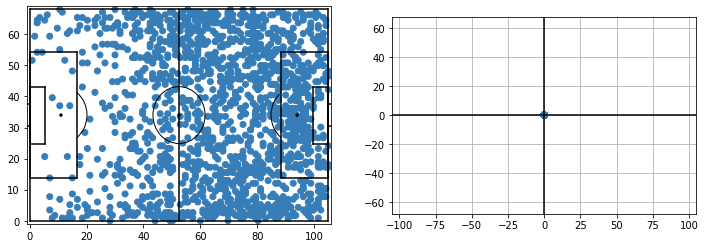

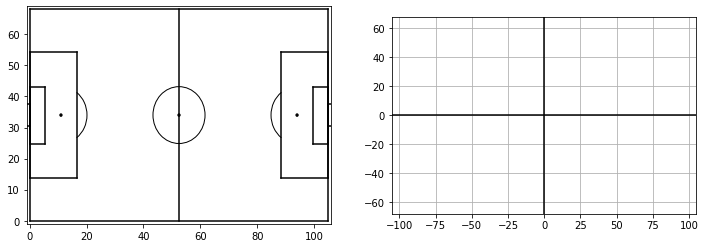

clearance 4 3015


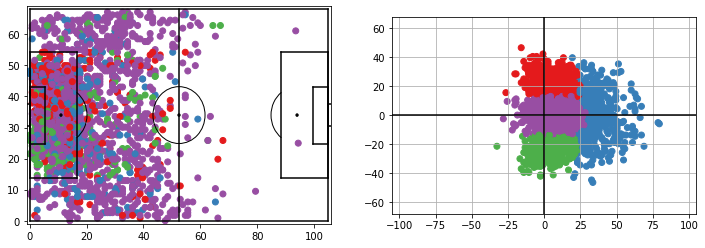

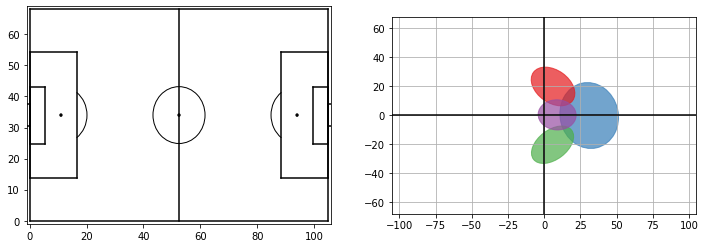

corner 7 698


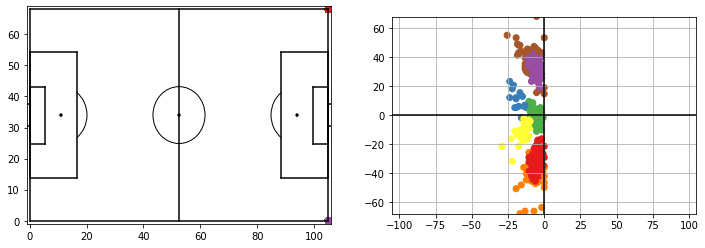

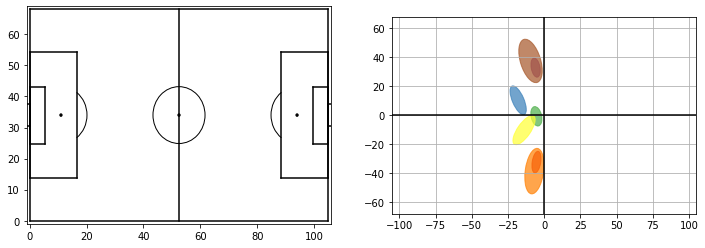

cross 6 1362


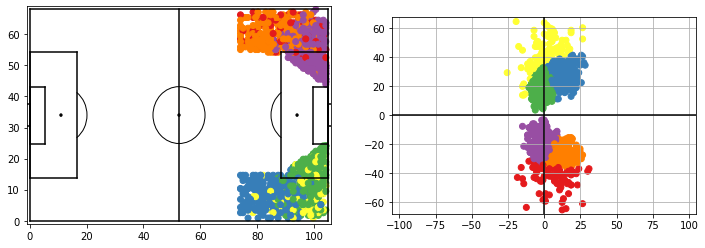

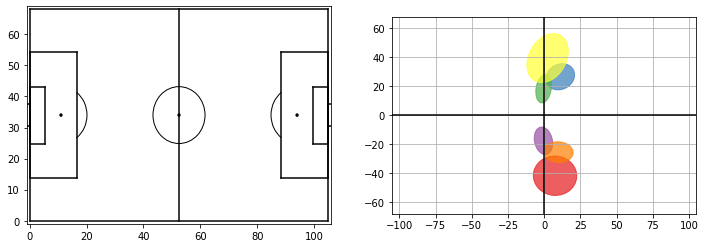

dribble 7 56151


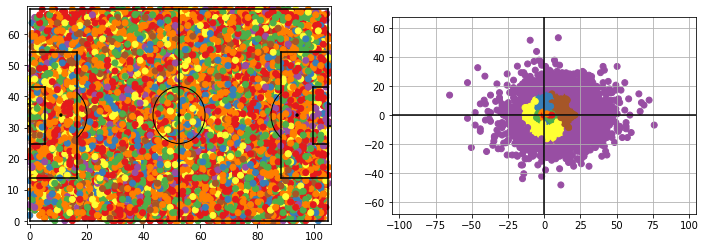

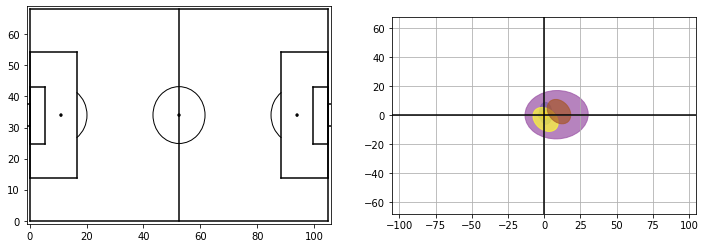

foul 1 1477


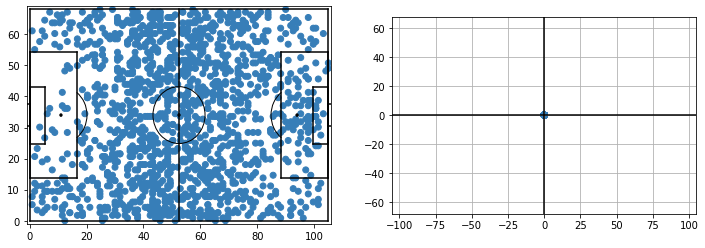

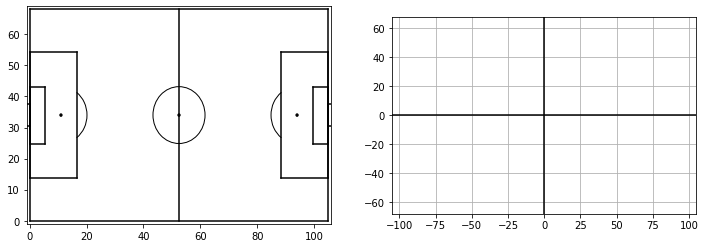

freekick 3 1465


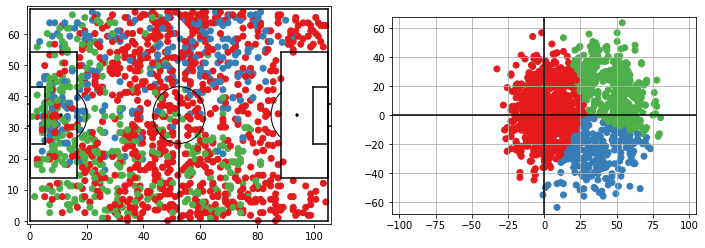

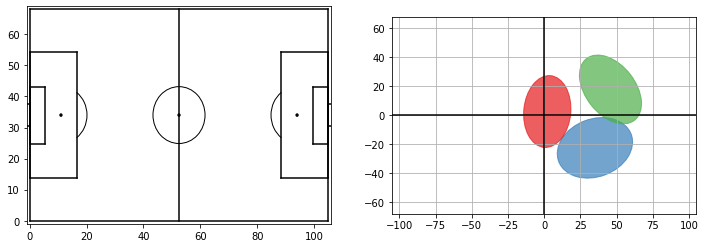

goal 1 158


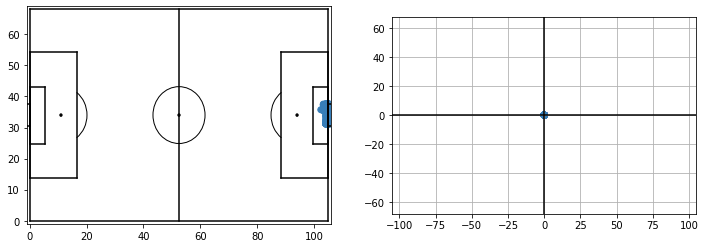

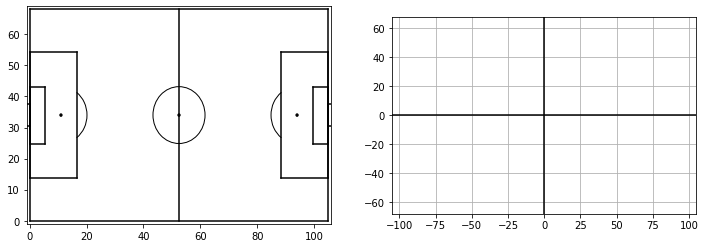

goalkick 7 1043


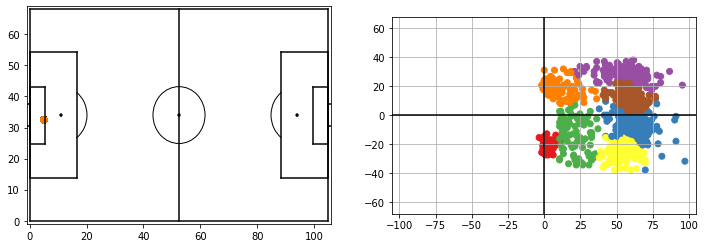

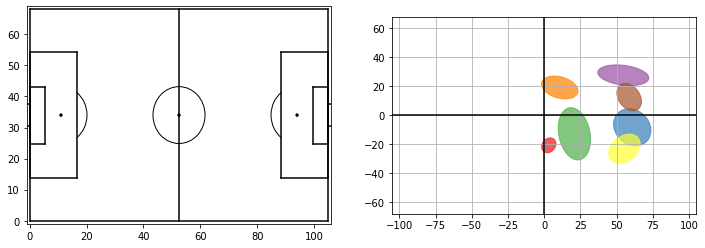

interception 1 12435


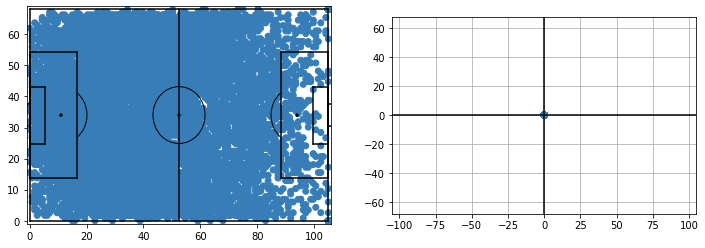

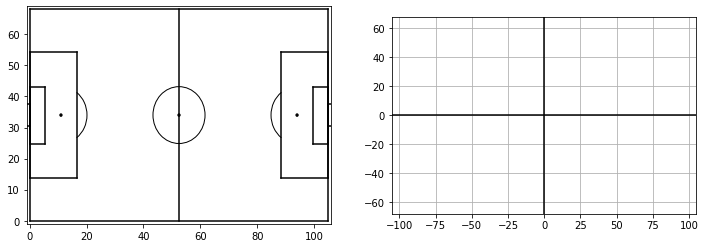

keeper_catch 1 674


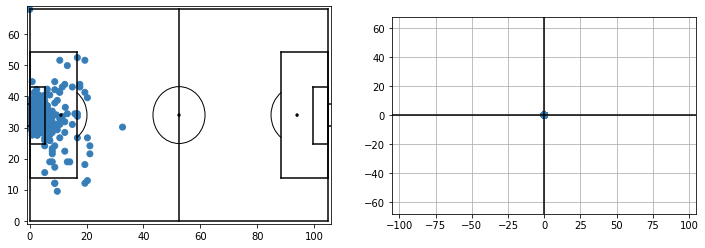

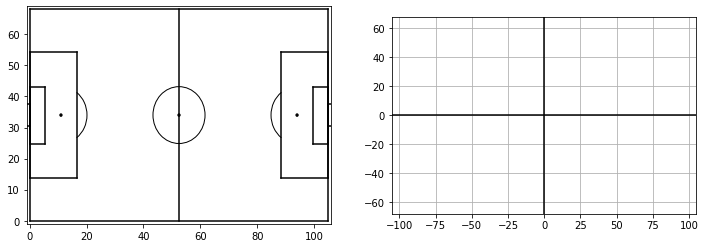

offside 1 246


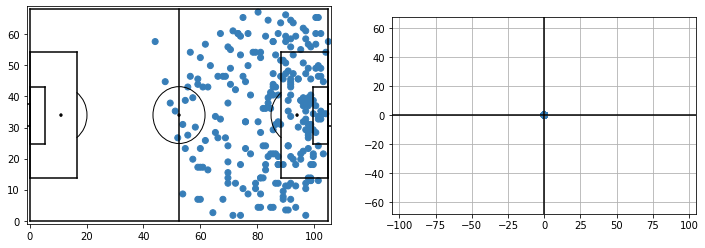

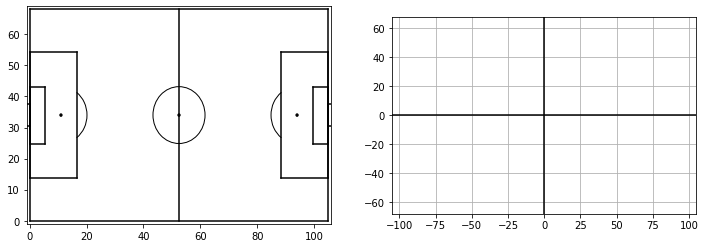

out 1 2628


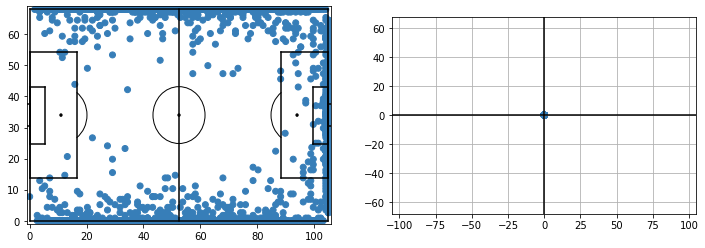

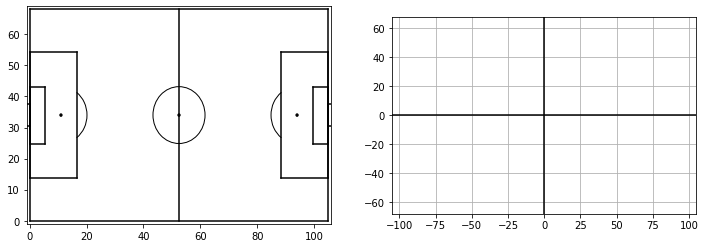

pass 2 56588


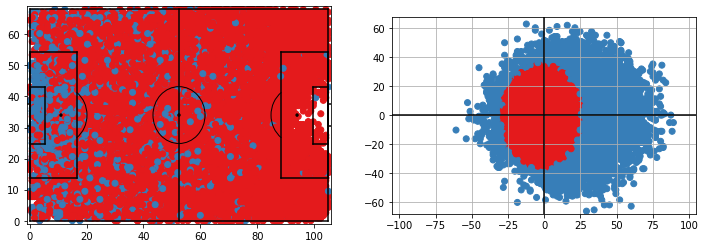

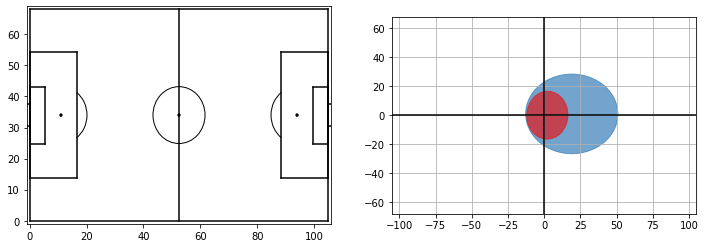

receival 1 51686


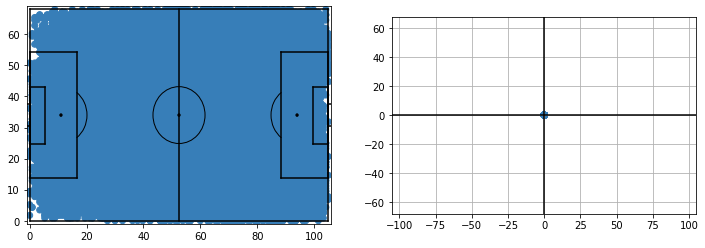

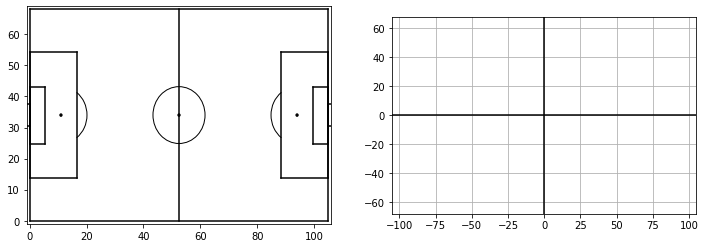

shot 5 1563


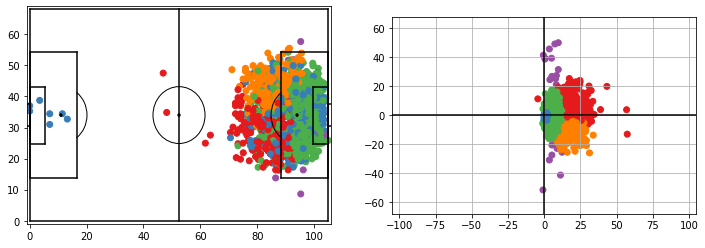

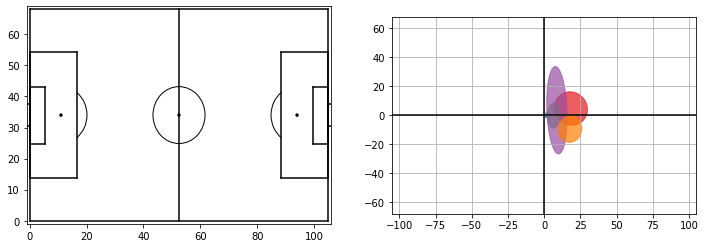

tackle 1 2259


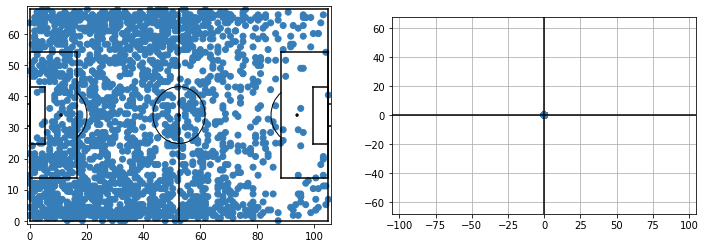

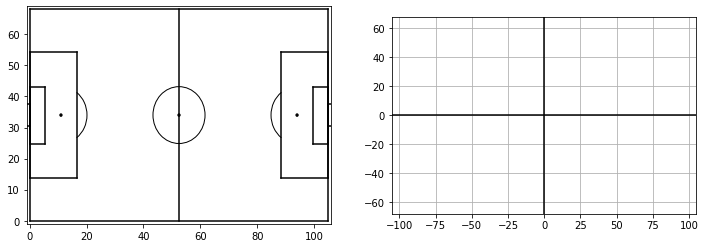

take_on 1 1980


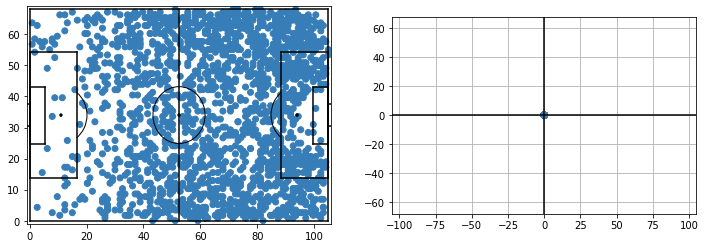

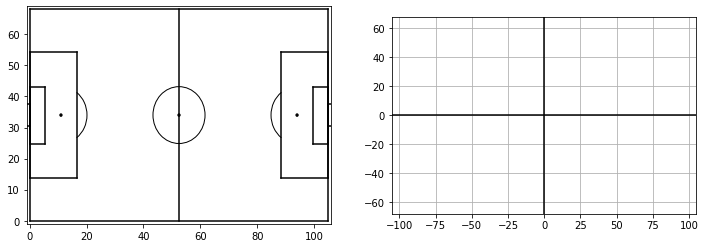

throw_in 7 2754


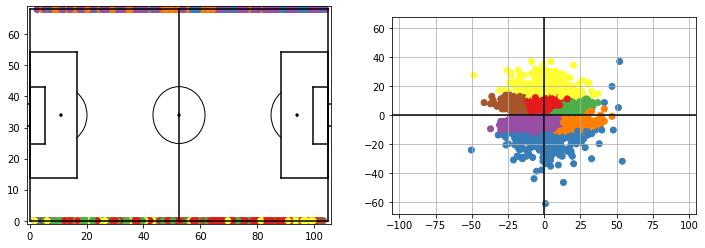

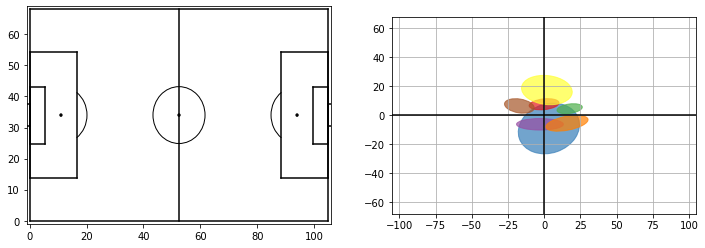

yellow_card 1 160


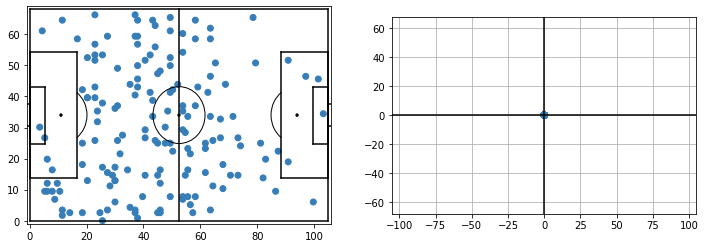

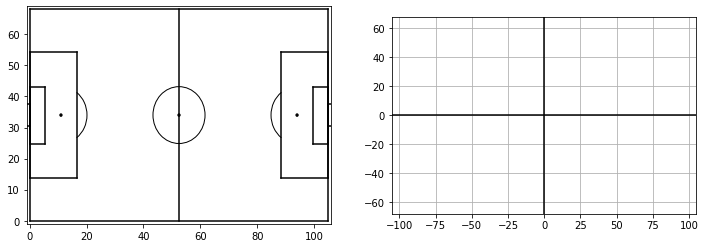

In [77]:
colors = ["#377eb8",
"#e41a1c",
"#4daf4a",
"#984ea3",
"#ff7f00",
"#ffff33",
"#a65628",
"#f781bf",
"#999999",
         ]
clustercolors = colors * 10

def sample(probs):
    n = len(probs)
    return np.random.choice(n,p=probs)

def plot_gmm(model):
    gmm = model["base"]
    a = model["df"]
    labelprobs = gmm.predict_proba(a)
    #labels = np.argmax(labelprobs,axis=1)
    labels = np.apply_along_axis(sample,axis=1, arr=labelprobs)
    clustercolors 
    plot_deltas(a.x,a.y,a.dx,a.dy,color=[clustercolors[l] for l in labels])
    for l in set(labels):
        l_idx = labels == l
        plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=clustercolors[l])
        
def plot_models_alpha(models):
    for k,model in models.items():
        gmm = model["base"]
        a = model["df"]
        print(k,gmm.n_components,len(a))
        labelprobs = gmm.predict_proba(a[model["cols"]])
        axs = prepare_axes()
        for i in range(gmm.n_components):
            color = clustercolors[i]
            alphas = labelprobs[:,i]
            r,g,b,_a = matplotlib.colors.to_rgba(color)
            rgbas = np.zeros((len(labelprobs),4))
            rgbas[:,0] = r
            rgbas[:,1] = g
            rgbas[:,2] = b
            rgbas[:,3] = alphas
            print(alphas.sum())
            axs[0].scatter(a.x,a.y,color=rgbas,s=1)
            axs[1].scatter(a.dx,a.dy,color=rgbas,s=1)
        plt.show()
    
        
def plot_models(models):
    for k,model in models.items():
        gmm = model["base"]
        a = model["df"]
        print(k,gmm.n_components,len(a))
        labelprobs = gmm.predict_proba(a[model["cols"]])
        labels = np.argmax(labelprobs,axis=1)
        #labels = np.apply_along_axis(sample,axis=1, arr=labelprobs)
        pcolors = [clustercolors[l] for l in labels]
        axs = prepare_axes()
        axs[0].scatter(a.x,a.y,color=pcolors)
        axs[1].scatter(a.dx,a.dy,color=pcolors)
        plt.show()
        
        axs = prepare_axes()
        for i in range(gmm.n_components):
            mean = gmm.means_[i,0:2]
            covar = gmm.covariances_[i,0:2,0:2]
            
#             v, w = linalg.eigh(covar)
#             v = 2. * np.sqrt(2.) * np.sqrt(v)
#             u = w[0] / linalg.norm(w[0])
            
#             # Plot an ellipse to show the Gaussian component
#             angle = np.arctan(u[1] / u[0])
#             angle = 180. * angle / np.pi  # convert to degrees
#             ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=clustercolors[i])
#             ell.set_clip_box(axs[0].bbox)
#             ell.set_alpha(0.7)
#             axs[0].add_artist(ell)
            
#             mean = gmm.means_[i,2:4]
#             covar = gmm.covariances_[i,2:4,2:4]
            
            v, w = linalg.eigh(covar)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])
            
            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=clustercolors[i])
            ell.set_clip_box(axs[0].bbox)
            ell.set_alpha(0.7)
            axs[1].add_artist(ell)
            
        plt.show()
#plot_gmm(models["clearance"])
plot_models(models)

In [37]:
class GMMEnsemble:
    
    def __init__(self,models):
        self.models = models
    
    def columns(self):
        return [k + str(i)
                for k in self.models
                for i in range(1,self.models[k].n_components+1)]
    
    def predict_proba(self,actions):
        components = self.columns()
        probs = np.zeros((len(actions),len(components)))
        i = 0
        for k,model in self.models.items():
            type_idx = actions.type_name == k
            if any(type_idx):
                type_probs = model.predict_proba(actions[type_idx][["x","y",
                                                                    #"dx","dy"
                                                                   ]])
                probs[type_idx,i:i+model.n_components] = type_probs
            i = i + model.n_components
        return pd.DataFrame(data=probs,columns=components)
        

gmme = GMMEnsemble({k:m["base"] for k,m in models.items()})
p = gmme.predict_proba(a)
p

bad_touch1  clearance1  clearance2  corner1  corner2  cross1  cross2  \
0              0.0         0.0         0.0      0.0      0.0     0.0     0.0   
1              0.0         0.0         0.0      0.0      0.0     0.0     0.0   
2              0.0         0.0         0.0      0.0      0.0     0.0     0.0   
3              0.0         0.0         0.0      0.0      0.0     0.0     0.0   
4              0.0         0.0         0.0      0.0      0.0     0.0     0.0   
...            ...         ...         ...      ...      ...     ...     ...   
199995         0.0         0.0         0.0      0.0      0.0     0.0     0.0   
199996         0.0         0.0         0.0      0.0      0.0     0.0     0.0   
199997         0.0         0.0         0.0      0.0      0.0     0.0     0.0   
199998         0.0         0.0         0.0      0.0      0.0     0.0     0.0   
199999         0.0         0.0         0.0      0.0      0.0     0.0     0.0   

        dribble1      dribble2  dribble3  ...  receival7     receival8  \
0       0.000000  0.000000e+00  0.000000  ...   0.000000  0.000000e+00   
1       0.000000  0.000000e+00  0.000000  ...   0.019422  1.224252e-29   
2       0.507336  1.199735e-03  0.004565  ...   0.000000  0.000000e+00   
3       0.000000  0.000000e+00  0.000000  ...   0.000000  0.000000e+00   
4       0.000000  0.000000e+00  0.000000  ...   0.704272  1.466080e-08   
...          ...           ...       ...  ...        ...           ...   
199995  0.000468  6.005759e-10  0.000139  ...   0.000000  0.000000e+00   
199996  0.000000  0.000000e+00  0.000000  ...   0.000000  0.000000e+00   
199997  0.000000  0.000000e+00  0.000000  ...   0.000000  0.000000e+00   
199998  0.000000  0.000000e+00  0.000000  ...   0.000000  0.000000e+00   
199999  0.000000  0.000000e+00  0.000000  ...   0.177425  9.507173e-02   

            receival9  shot1  shot2  tackle1  take_on1  throw_in1  throw_in2  \
0        0.000000e+00    0.0    0.0      0.0       0.0        0.0        0.0   
1        5.825014e-60    0.0    0.0      0.0       0.0        0.0        0.0   
2        0.000000e+00    0.0    0.0      0.0       0.0        0.0        0.0   
3        0.000000e+00    0.0    0.0      0.0       0.0        0.0        0.0   
4       6.279411e-132    0.0    0.0      0.0       0.0        0.0        0.0   
...               ...    ...    ...      ...       ...        ...        ...   
199995   0.000000e+00    0.0    0.0      0.0       0.0        0.0        0.0   
199996   0.000000e+00    0.0    0.0      0.0       0.0        0.0        0.0   
199997   0.000000e+00    0.0    0.0      0.0       0.0        0.0        0.0   
199998   0.000000e+00    0.0    0.0      0.0       0.0        1.0        0.0   
199999  2.178225e-190    0.0    0.0      0.0       0.0        0.0        0.0   

        yellow_card1  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...              ...  
199995           0.0  
199996           0.0  
199997           0.0  
199998           0.0  
199999           0.0  

[200000 rows x 50 columns]

In [15]:
sum(p[c].sum() for c in p.columns if "pass" in c)

56587.99999999999

In [38]:
nex_actions = a.shift(-1)
valid_idx = (a.team_id == nex_actions.team_id) & (a.period_id == nex_actions.period_id)
print(sum(valid_idx)/ len(valid_idx))
prev = gmme.predict_proba(a[valid_idx])
nex = gmme.predict_proba(nex_actions[valid_idx])
prev,nex
#gmme.predict_proba(a[valid_idx])

0.879875


(        bad_touch1  clearance1  clearance2  corner1  corner2  cross1  cross2  \
 0              0.0         0.0         0.0      0.0      0.0     0.0     0.0   
 1              0.0         0.0         0.0      0.0      0.0     0.0     0.0   
 2              0.0         0.0         0.0      0.0      0.0     0.0     0.0   
 3              0.0         0.0         0.0      0.0      0.0     0.0     0.0   
 4              0.0         0.0         0.0      0.0      0.0     0.0     0.0   
 ...            ...         ...         ...      ...      ...     ...     ...   
 175970         0.0         0.0         0.0      0.0      0.0     0.0     0.0   
 175971         0.0         0.0         0.0      0.0      0.0     0.0     0.0   
 175972         0.0         0.0         0.0      0.0      0.0     0.0     0.0   
 175973         0.0         0.0         0.0      0.0      0.0     0.0     0.0   
 175974         0.0         0.0         0.0      0.0      0.0     0.0     0.0   
 
         dribble1      dri

(50, 175975)


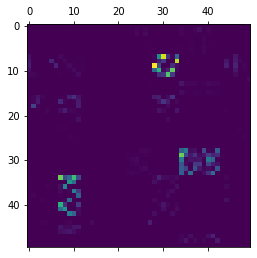

In [39]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
print(prev.T.shape)
trans = np.dot(prev.T,nex)
#trans /= trans.sum()
#for i in range(len(trans)):
    #p(trans[:,i].sum())
plt.matshow(trans)
plt.show()
#trans = np.dot(trans.T,trans)
#trans.sum(),prev.sum()

136.76779938675116 44 14
shot2 (blue) -> goal1 (red)


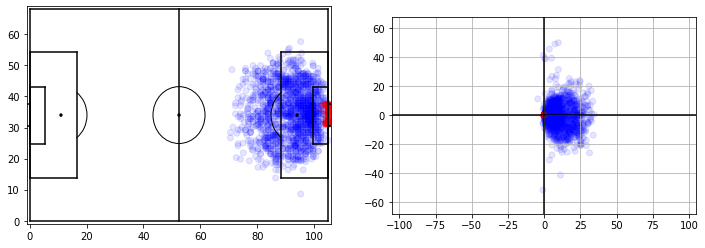

23.0 45 15
tackle1 (blue) -> goalkick1 (red)


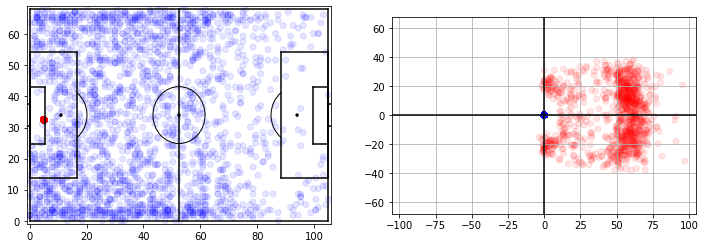

19.585300615051516 38 15
receival5 (blue) -> goalkick1 (red)


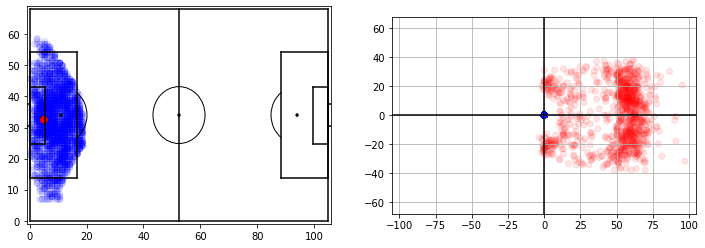

5.588462381675175 11 15
dribble5 (blue) -> goalkick1 (red)


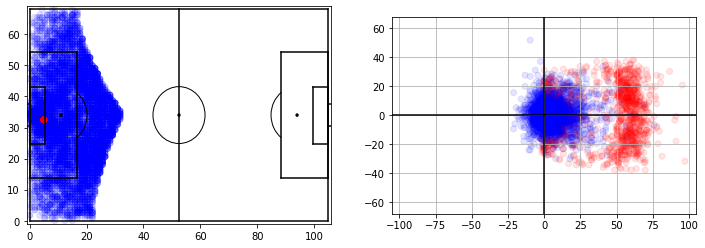

In [60]:
probs = []
for i in range(len(trans)):
    for j in range(len(trans)):
        probs.append((trans[i,j],i,j))
probs = sorted(probs,reverse=True)
movs = [(p,i,j) for p,i,j in probs]# if i != j]

labelprobs = gmme.predict_proba(a).values
labels = np.argmax(labelprobs,axis=1)

for p,i,j in movs[:1000]:
    cols = gmme.columns()
    if "goal" in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=twocolors)
    if p < 5:
        break

In [12]:
set(actions.type_name)
colors = ["#e41a1c",
"#377eb8",
"#4daf4a",
"#984ea3",
"#ff7f00",
"#ffff33",
"#a65628",
"#f781bf",
"#999999",
         ]
clustercolors = colors * 10
atoh = fs.feature_column_names([fs.actiontype_onehot],1)
atoh

['type_pass_a0',
 'type_cross_a0',
 'type_throw_in_a0',
 'type_freekick_crossed_a0',
 'type_freekick_short_a0',
 'type_corner_crossed_a0',
 'type_corner_short_a0',
 'type_take_on_a0',
 'type_foul_a0',
 'type_tackle_a0',
 'type_interception_a0',
 'type_shot_a0',
 'type_shot_penalty_a0',
 'type_shot_freekick_a0',
 'type_keeper_save_a0',
 'type_keeper_claim_a0',
 'type_keeper_punch_a0',
 'type_keeper_pick_up_a0',
 'type_clearance_a0',
 'type_bad_touch_a0',
 'type_non_action_a0',
 'type_dribble_a0',
 'type_goalkick_a0',
 'type_receival_a0',
 'type_out_a0',
 'type_offside_a0',
 'type_goal_a0',
 'type_owngoal_a0',
 'type_yellow_card_a0',
 'type_red_card_a0']

In [37]:
actions.type_name.value_counts(True)
varxy = actions.groupby("type_name")[["x","y"]].var().reset_index()
actions["count"] = 1
atcnt = actions.groupby("type_name")["count"].count().reset_index()
atcnt.merge(varxy)

type_name   count            x            y
0          bad_touch    9472   534.257857   455.668058
1          clearance   18135   166.109950   174.622941
2     corner_crossed    3128     0.012196  1156.016064
3       corner_short     754     0.000000  1156.362419
4              cross    8284    63.861126   569.783320
5            dribble  332431   583.727206   409.534980
6               foul    8924   553.926228   414.949383
7   freekick_crossed    4428   791.884475   412.487971
8     freekick_short    4060   364.977735   392.632053
9               goal    1040     0.232600     6.167996
10          goalkick    5834     0.194670     7.859471
11      interception   72423   598.644162   317.366639
12      keeper_claim    1213    38.882856    48.628760
13      keeper_punch     446     6.803589    10.040855
14       keeper_save    2168     2.827695    12.272351
15           offside     247   169.314370   304.837502
16               out    7656  1167.161373   683.424283
17           owngoal      32    14.829274     7.372472
18              pass  337078   519.912978   389.738648
19          receival  306372   553.627034   412.412584
20          red_card      27   502.490906   333.313120
21              shot    9199    82.545657    66.206685
22     shot_freekick     351    32.659520   110.553588
23      shot_penalty     103     0.156167     0.143297
24            tackle   13034   588.782097   512.162356
25           take_on   11675   567.954197   473.075591
26          throw_in   16380   690.701621  1156.056083
27       yellow_card     989   512.480911   392.434289

100000
Initialization 0
  Iteration 10	 time lapse 57.82250s	 ll change 0.11421
  Iteration 20	 time lapse 50.02293s	 ll change 0.00032
Initialization converged: True	 time lapse 107.84572s	 ll 167.07470


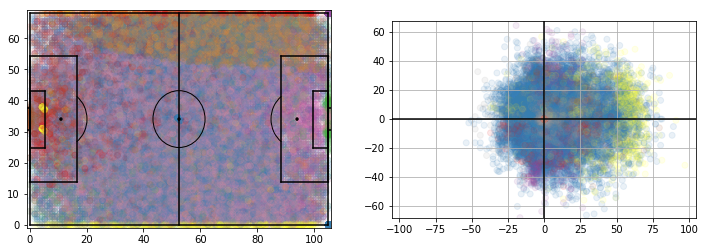

['x', 'y', 'dx', 'type_throw_in_a0']


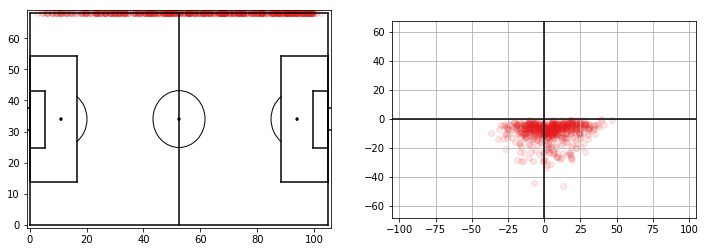

['x', 'y', 'type_foul_a0']


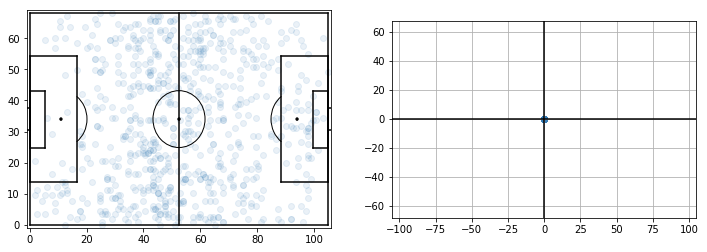

['x', 'y', 'type_tackle_a0']


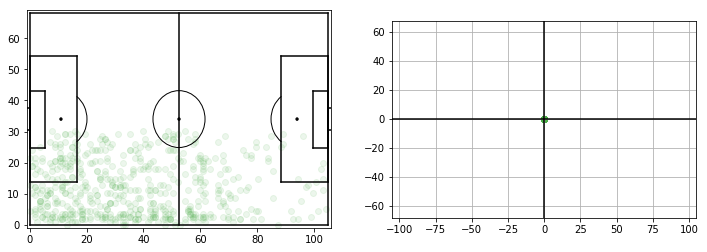

['x', 'y', 'type_offside_a0']


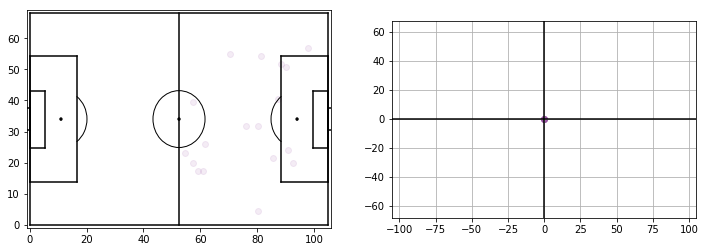

['x', 'y', 'type_receival_a0']


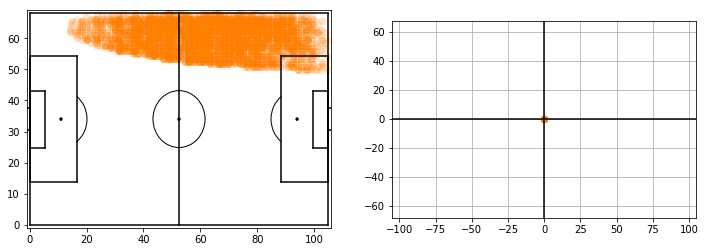

['x', 'y', 'dx', 'dy', 'type_freekick_crossed_a0', 'type_goalkick_a0']


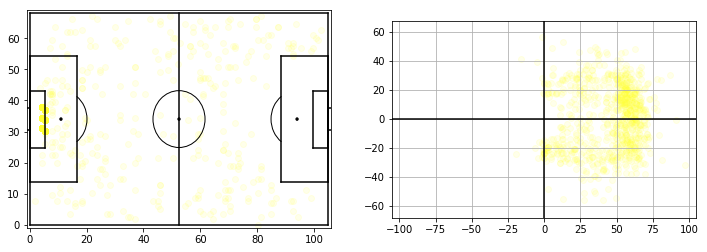

['x', 'y', 'type_keeper_save_a0', 'type_keeper_claim_a0', 'type_keeper_punch_a0', 'type_owngoal_a0']


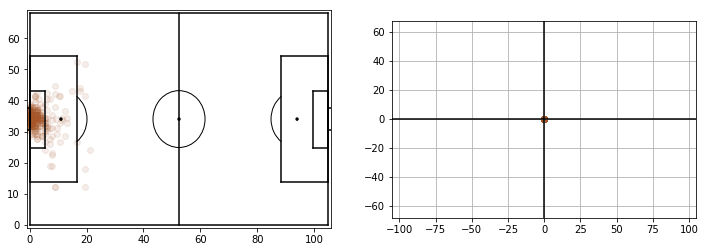

['x', 'y', 'type_interception_a0']


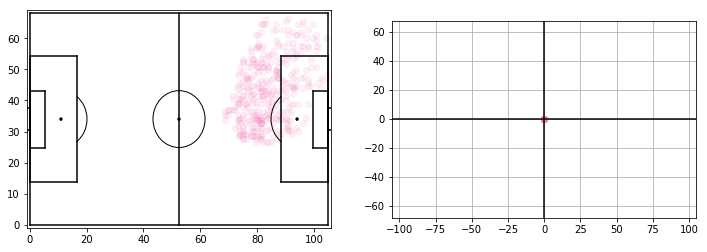

['x', 'y', 'type_interception_a0']


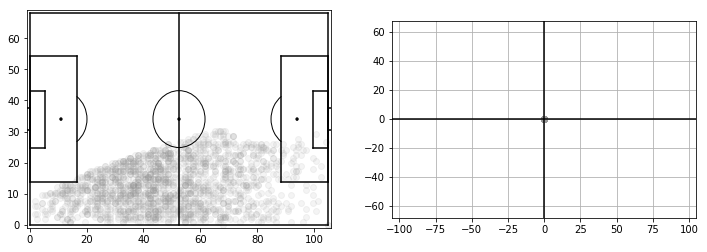

['x', 'y', 'type_tackle_a0']


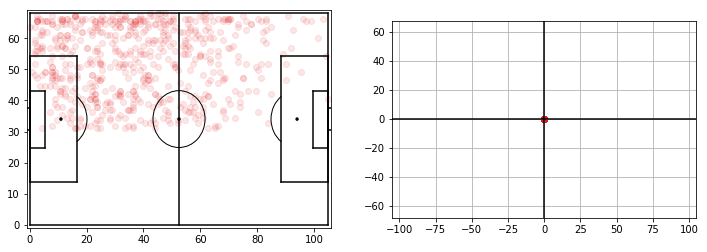

['x', 'dy', 'type_corner_crossed_a0', 'type_corner_short_a0']


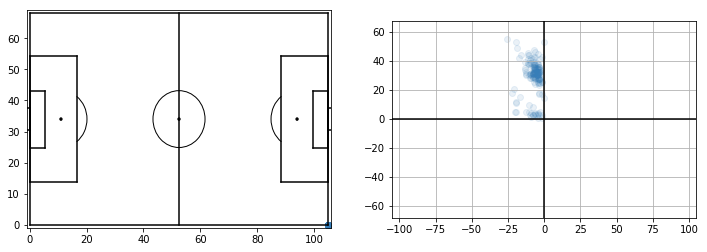

['x', 'y', 'type_out_a0', 'type_yellow_card_a0']


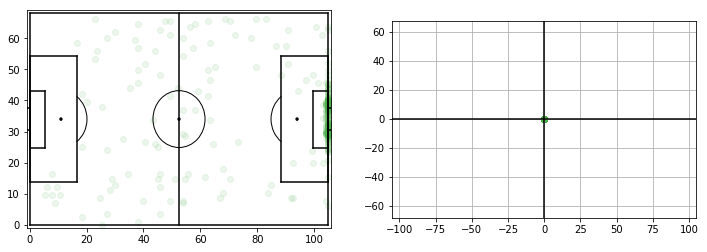

['x', 'y', 'dx', 'dy', 'type_cross_a0', 'type_shot_freekick_a0']


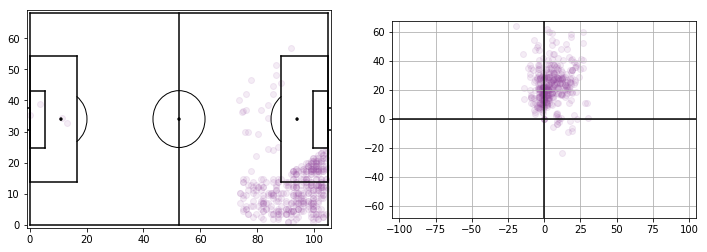

['x', 'y', 'type_bad_touch_a0']


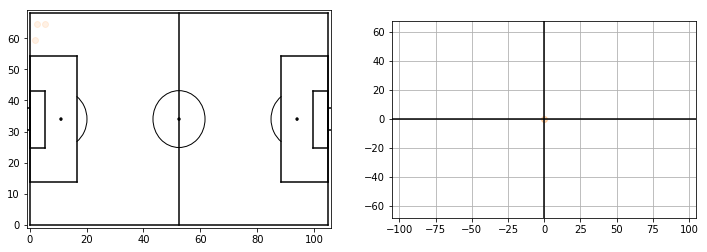

['x', 'y', 'type_out_a0']


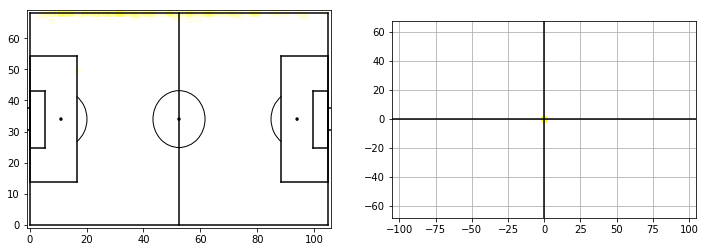

['x', 'y', 'type_bad_touch_a0']


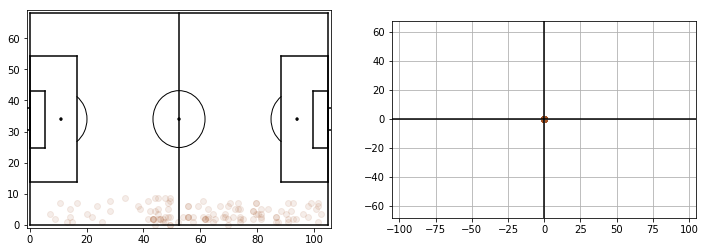

['x', 'y', 'dx', 'dy', 'type_shot_penalty_a0', 'type_goal_a0']


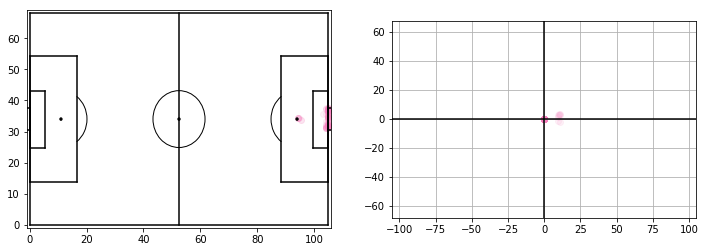

['x', 'y', 'type_out_a0']


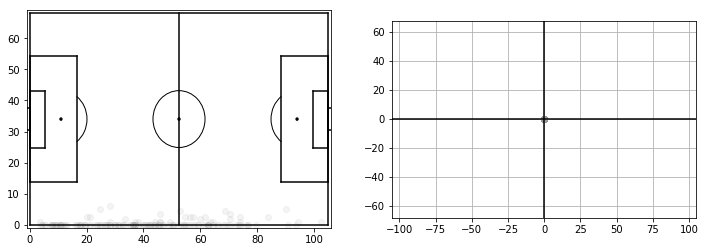

['x', 'y', 'type_interception_a0']


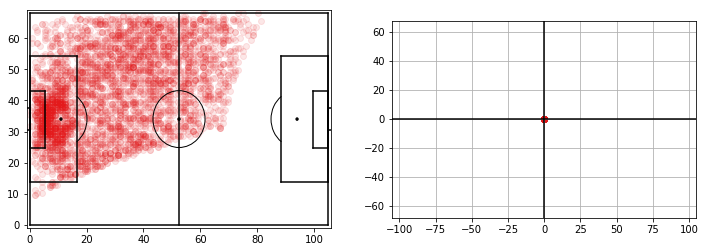

['x', 'y', 'dx', 'dy', 'type_pass_a0', 'type_freekick_short_a0']


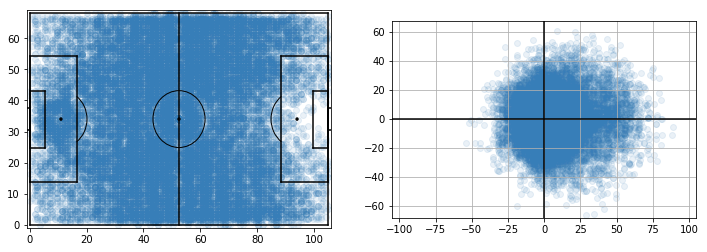

['x', 'y', 'type_bad_touch_a0']


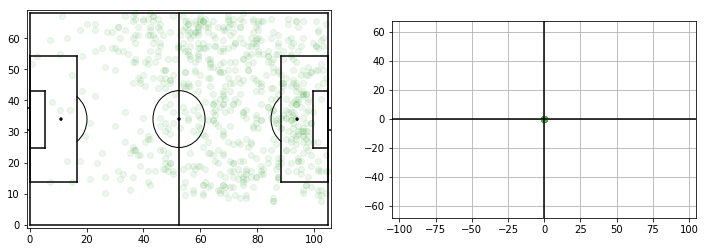

['x', 'y', 'dx', 'type_cross_a0', 'type_corner_crossed_a0', 'type_corner_short_a0', 'type_shot_a0']


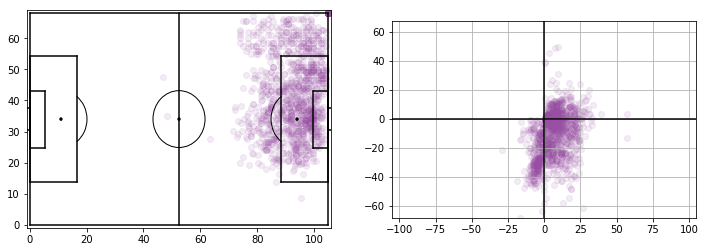

['x', 'y', 'type_take_on_a0']


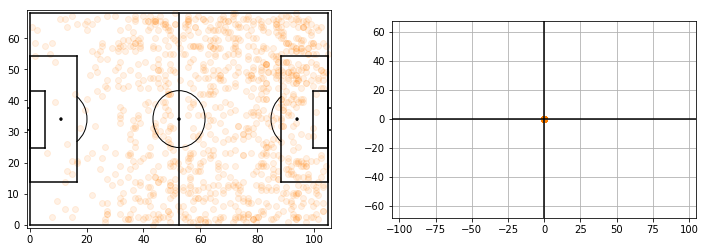

['x', 'dx', 'dy', 'type_throw_in_a0']


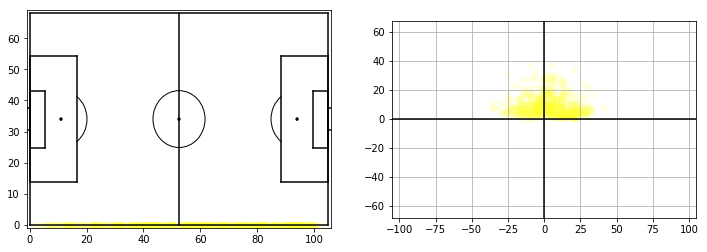

['x', 'y', 'dx', 'dy', 'type_clearance_a0']


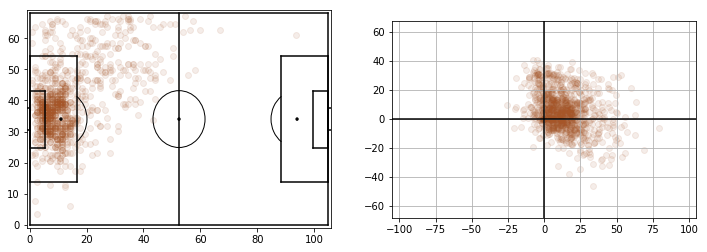

['x', 'y', 'type_receival_a0']


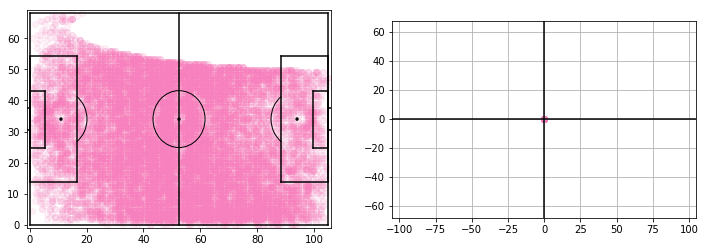

['x', 'y', 'dx', 'type_dribble_a0']


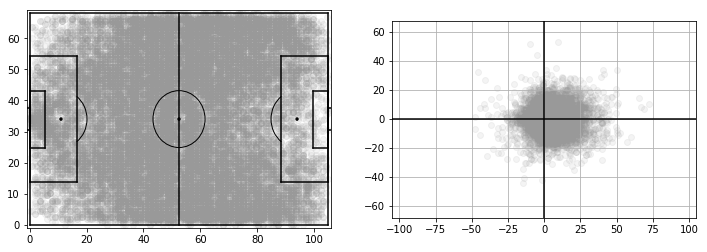

['x', 'y', 'dx', 'type_clearance_a0']


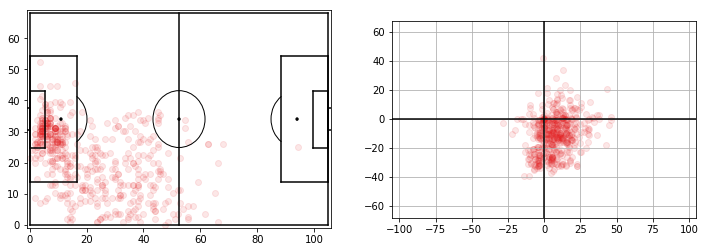

CPU times: user 8min 15s, sys: 4min 47s, total: 13min 2s
Wall time: 2min 40s


In [39]:
%%time
import sklearn.cluster as clus
import sklearn.mixture as mix
import socceraction.atomic.features as fs

a = actions[:100000].copy()

#a = actions[actions.type_name == "pass"][:40000].copy()
a = a.fillna(0)
#a = actions[:100000].copy()
print(len(a))
di = fs.direction(a)
#a["dx"] = di.dx_a0
#a["dy"] = di.dy_a0
a[atoh]= fs.actiontype_onehot(a).applymap(int)
nbc = 28

cols = ["x","y", "dx","dy"] + atoh

# gmm = mix.GaussianMixture(nbc,verbose=2).fit(a[["x","y",
#                                       "dx","dy",
#                                      ]])
gmm = mix.GaussianMixture(nbc,verbose=2).fit(a[cols])
#color_clusters([(x,y) for (x,y,dx,dy) in gmm.means_],colors)
#print(clustercolors)
labels = gmm.predict(a[cols])
#                      [["x","y",
#                         "dx","dy",
#                        ]])

plot_deltas(a.x,a.y,a.dx,a.dy,color=[clustercolors[l] for l in labels])
for l in set(labels):
    l_idx = labels == l
    m = [cols[i] for i, v in enumerate(gmm.means_[l]) if v > 0.01]
    print(list(m))
    plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=clustercolors[l])

In [59]:
cols = ["x","y", "dx","dy"]

models = {}
bics = {}
a = actions[:100000].copy().fillna(0)
for type_name, df in a.groupby("type_name"):
    if len(df) > 10:
        print(type_name,len(df))
        typemodels = list([mix.GaussianMixture(nbc).fit(df[cols]) for nbc in range(1,11)])
        typebics = list([m.bic(df[cols]) for m in typemodels])
        models[type_name] = typemodels
        bics[type_name] = typebics

bad_touch 810
clearance 1519
corner_crossed 276
corner_short 67
cross 703
dribble 28544
foul 719
freekick_crossed 333
freekick_short 321
goal 87
goalkick 477
interception 5932
keeper_claim 109
keeper_punch 26
keeper_save 185
offside 18
out 640
pass 28637
receival 26172
shot 813
shot_freekick 23
tackle 1139
take_on 1021
throw_in 1343
yellow_card 73


bad_touch
clearance
corner_crossed
corner_short
cross
dribble
foul
freekick_crossed
freekick_short
goal
goalkick
interception
keeper_claim
keeper_punch
keeper_save
offside
out
pass
receival
shot
shot_freekick
tackle
take_on
throw_in
yellow_card


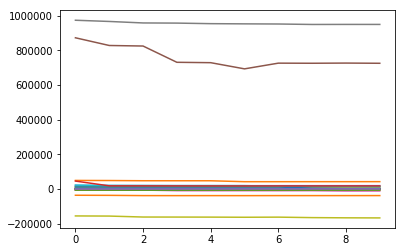

[(-162516.1915142636, 'receival'),
 (-38452.45182550786, 'interception'),
 (-10822.144445894273, 'out'),
 (-6805.350780133959, 'tackle'),
 (-5966.875768046955, 'take_on'),
 (-4743.5483299723965, 'bad_touch'),
 (-4153.173515891293, 'foul'),
 (-2761.1178238338102, 'corner_crossed'),
 (-2708.838214466093, 'keeper_save'),
 (-1840.105537095745, 'goal'),
 (-1071.902296285084, 'keeper_claim'),
 (-362.7052226961423, 'corner_short'),
 (-217.98195850259233, 'keeper_punch'),
 (-208.19372016131115, 'yellow_card'),
 (-26.854392995879635, 'offside'),
 (520.8244714371864, 'shot_freekick'),
 (10865.574433210566, 'freekick_short'),
 (11202.15054202995, 'freekick_crossed'),
 (11216.87312484022, 'goalkick'),
 (17518.480239948847, 'throw_in'),
 (18946.00642343701, 'cross'),
 (19357.040524441694, 'shot'),
 (47291.98975242965, 'clearance'),
 (728725.9263185667, 'dribble'),
 (953876.5395224964, 'pass')]

In [62]:
bicdiff = [((v[4]),k) for k,v in bics.items()]
for k,v in bics.items():
    print(k)
    plt.plot(v)
    #plt.show()
plt.show()
sorted(list(bicdiff))

In [25]:
states = gmm.predict_proba(actions[["x","y"]])
states.shape

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1188669 but corresponding boolean dimension is 1188670

In [184]:
actions = actions.fillna(0)
nex_actions = a.shift(-1)
valid_idx = (actions.team_id == nex_actions.team_id) & (actions.period_id == nex_actions.period_id)
print(sum(valid_idx)/ len(valid_idx))
prev = gmm.predict_proba(actions[valid_idx][["x","y","dx","dy"]])
nex = gmm.predict_proba(nex_actions[valid_idx][["x","y","dx","dy"]])
prev,nex

0.8807810409953982


(array([[0.   , 0.   , 0.   , ..., 0.   , 0.004, 0.   ],
        [0.   , 0.   , 0.   , ..., 0.128, 0.054, 0.   ],
        [0.   , 0.   , 0.   , ..., 0.128, 0.054, 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.004, 0.   , 0.157],
        [0.   , 0.   , 0.   , ..., 0.004, 0.   , 0.157],
        [0.   , 0.   , 0.   , ..., 0.   , 0.006, 0.   ]]),
 array([[0.   , 0.   , 0.   , ..., 0.128, 0.054, 0.   ],
        [0.   , 0.   , 0.   , ..., 0.128, 0.054, 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.001, 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.004, 0.   , 0.157],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]]))

(150, 175975)


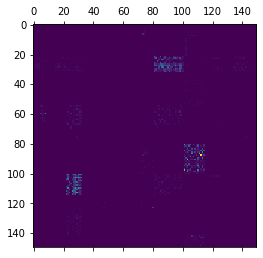

(1.0, bad_touch1       17.705032
 bad_touch2        9.719267
 bad_touch3       29.170574
 bad_touch4       31.419174
 bad_touch5       35.985953
                    ...    
 throw_in4       138.195418
 throw_in5       195.927093
 throw_in6       192.422760
 throw_in7       160.371360
 yellow_card1      0.000000
 Length: 150, dtype: float64)

In [ ]:
probs = []
for i in range(nbc):
    for j in range(nbc):
        probs.append((trans[i,j],i,j))
probs = sorted(probs,reverse=True)
movs = [(p,i,j) for p,i,j in probs if i != j]

labels = np.argmax

for p,i,j in movs[:20]:
    
    labels = g
    
    l_idx = (labels == i) | (labels == j)
    twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
    plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=twocolors)

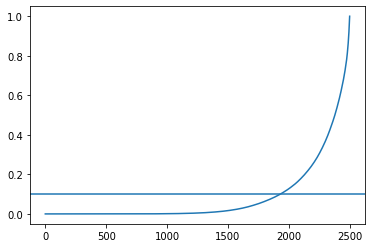

In [226]:
plt.plot(np.cumsum(sorted(trans.flatten())))
plt.axhline(0.1)
plt.show()

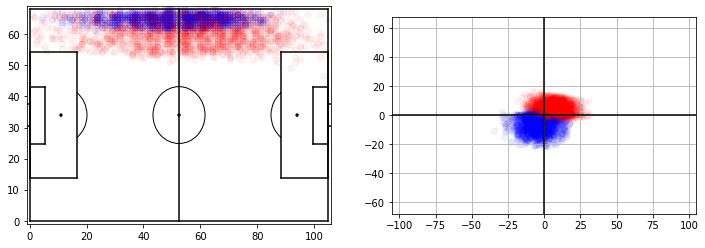

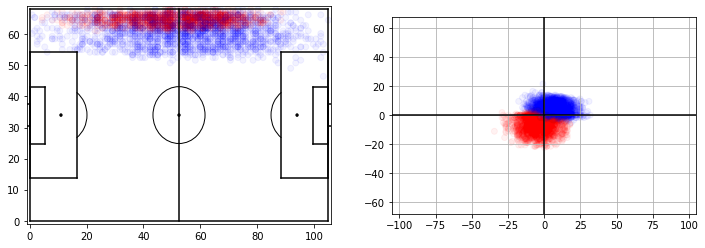

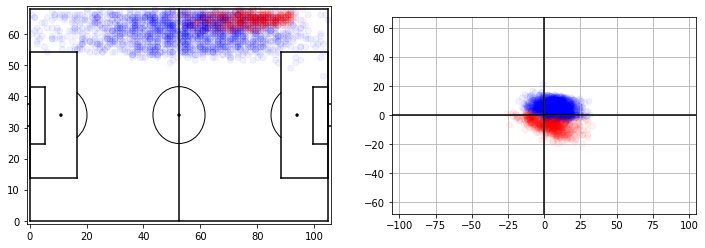

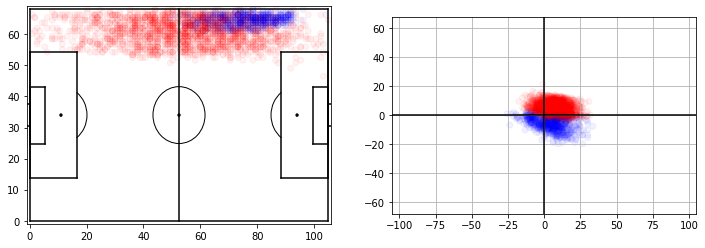

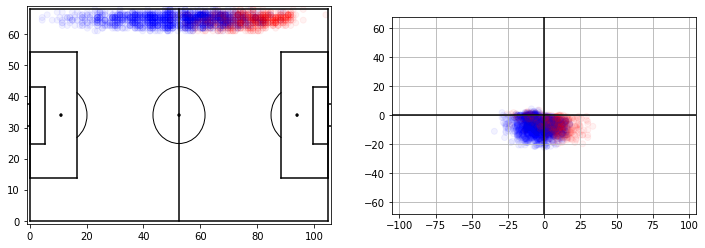

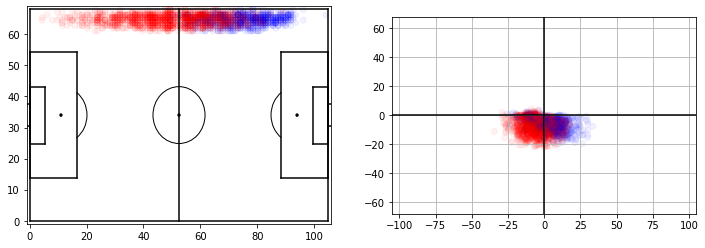

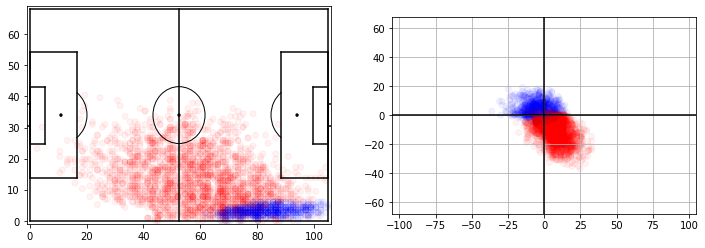

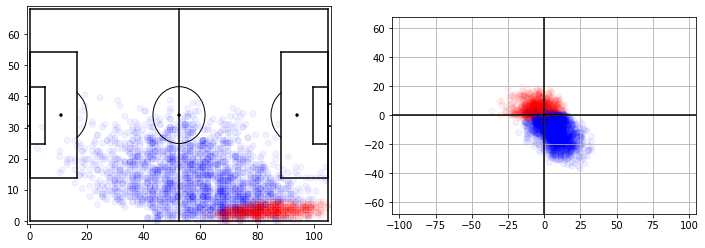

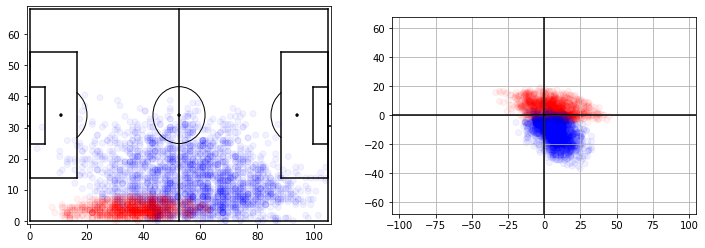

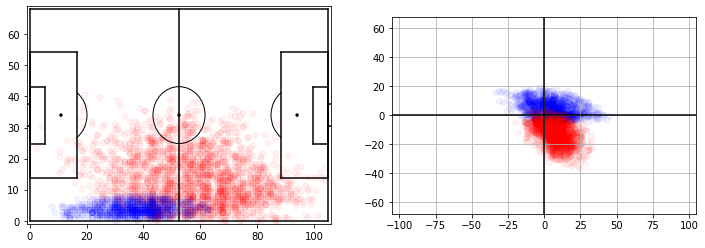

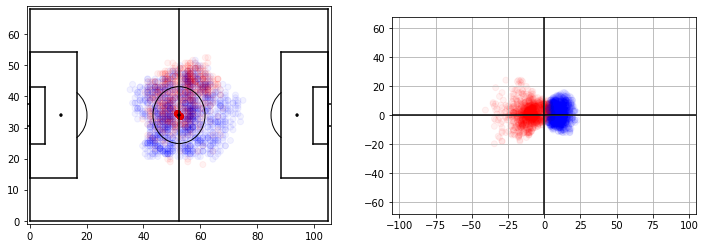

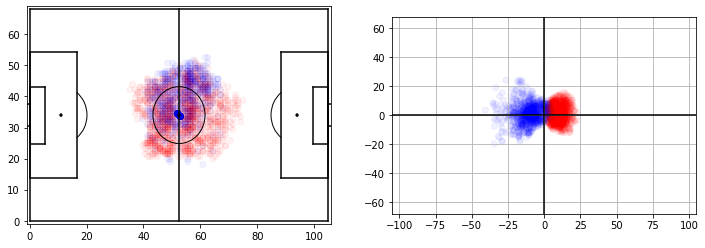

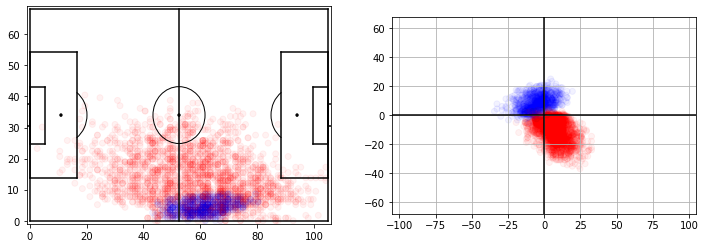

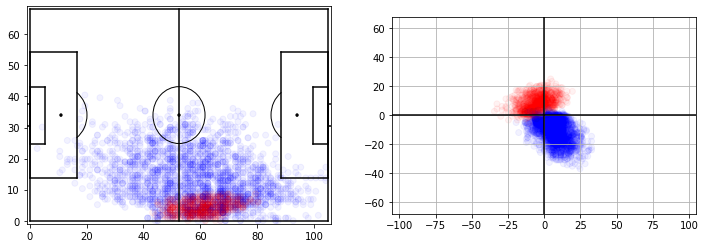

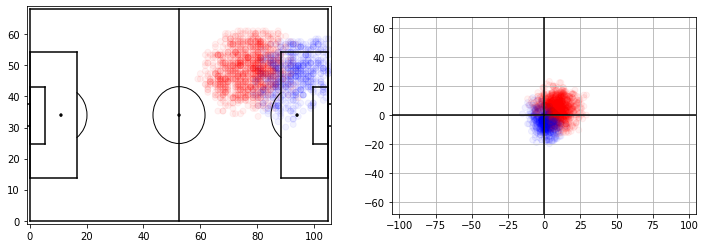

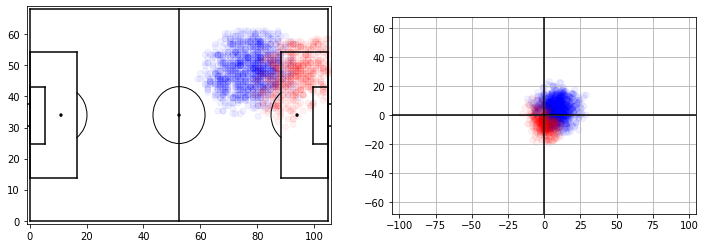

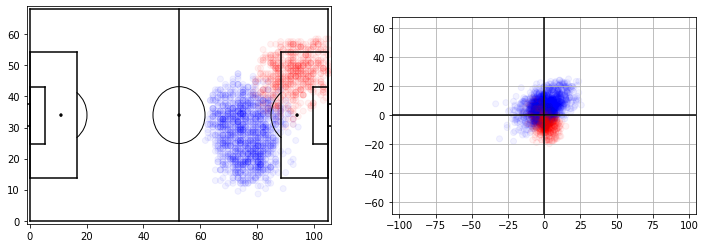

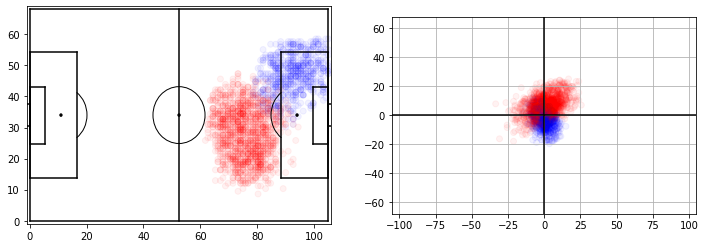

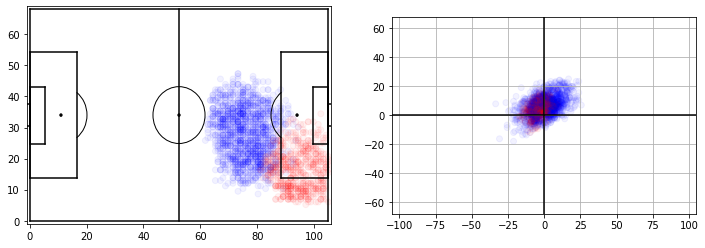

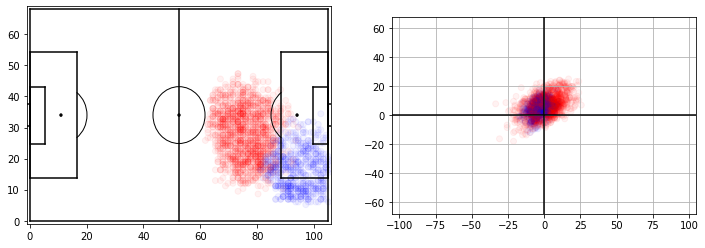

In [186]:
probs = []
for i in range(nbc):
    for j in range(nbc):
        probs.append((trans[i,j],i,j))
probs = sorted(probs,reverse=True)
movs = [(p,i,j) for p,i,j in probs if i != j]
for p,i,j in movs[:20]:
    l_idx = (labels == i) | (labels == j)
    twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
    plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=twocolors)

Text(0.5, 0, 'n_components')

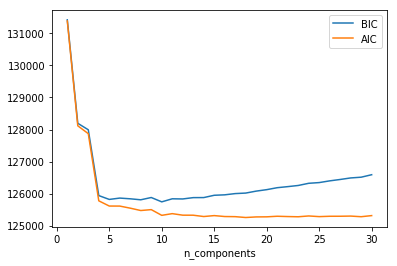

In [136]:
n_components = np.arange(1, 31)
models = [mix.GaussianMixture(n).fit(a[["x","y"]])
          for n in n_components]

plt.plot(n_components, [m.bic(a[["x","y"]]) for m in models], label='BIC')
plt.plot(n_components, [m.aic(a[["x","y"]]) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

100%|██████████| 370/370 [00:00<00:00, 459.07it/s]


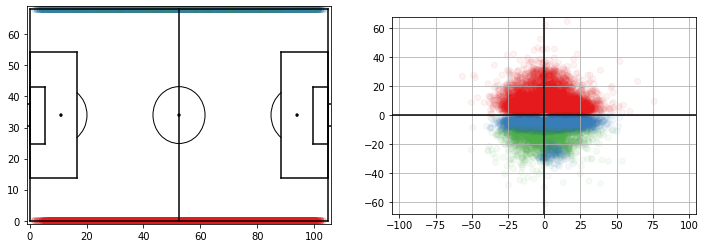

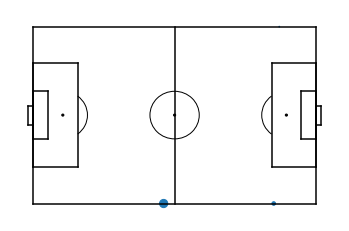

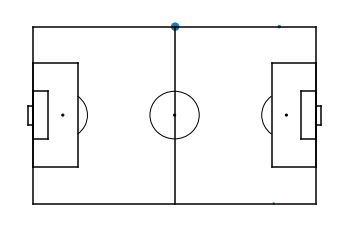

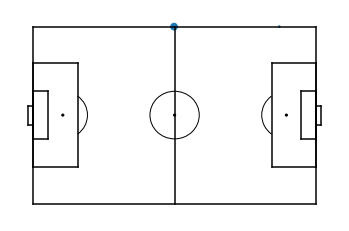

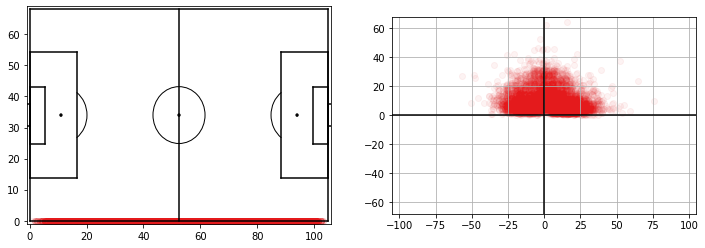

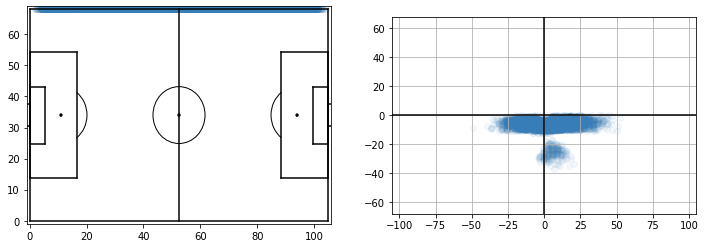

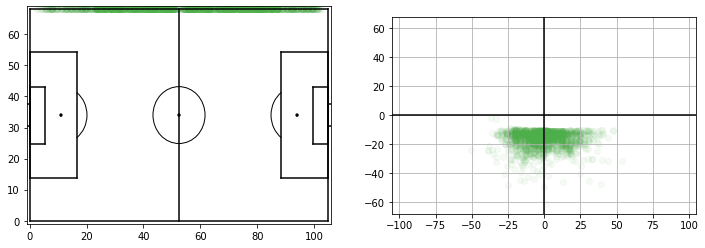

In [201]:
import numpy

nbp = len(set(a.player_id))
vectors = np.zeros((nbp,nbc))

player_ids = []
for i,(player_id,df) in tqdm.tqdm(list(enumerate(a.groupby(["player_id"])))):
    probs = gmm.predict_proba(df[["x","y"
                                  ,"dx","dy"
                                 ]])
    playervector = probs.mean(axis=0)
    player_ids.append(player_id)
    vectors[i,:] = playervector
#vectors


from sklearn.decomposition import NMF
model = NMF(3).fit(vectors)
from sklearn.decomposition import LatentDirichletAllocation as LDA
#model = LDA(6).fit(vectors)
model.components_

components = []
for c in model.components_:
    components.append(c/c.sum())
#model.components_ = np.array(components)
model.components_ = model.components_ / np.linalg.norm(model.components_)

#print(model.components_ )

x = np.array([cc[0] for cc in gmm.means_])
y = np.array([cc[1] for cc in gmm.means_])

# ax = mps.field(show=False)
# for component in model.components_:
#     c_idx = component > 0.1
    
#     ax.scatter(x,y,s=100*component,alpha=0.5)
#     #plt.show()
# plt.show()    

def predict_cluster(points,gmm,nmf):
    gaussprobs = gmm.predict_proba(points)
    clusterscores = nmf.transform(gaussprobs)
    return np.argmax(clusterscores,axis=1)

points = a[["x","y",
            "dx","dy",
           ]].values
clusterlabels = predict_cluster(points,gmm,model)

#ax = mps.field(show=False)
plot_deltas(a.x,a.y,a.dx,a.dy,[list(colors*10)[l] for l in clusterlabels])
#ax.scatter(x,y,color=[colors[l] for l in clusterlabels])
#plt.show()

x = np.array([cc[0] for cc in gmm.means_])
y = np.array([cc[1] for cc in gmm.means_])

for component in model.components_:
    c_idx = component > 0.1
    ax = mps.field(show=False)
    ax.scatter(x,y,s=100*component,alpha=1)
    plt.show()

for l in set(clusterlabels):
    l_idx = clusterlabels == l
    plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=(colors * 10)[l])

(array([ 842., 2767., 9516., 9579., 6379., 4105., 2657., 1363., 1491.,
        1301.]),
 array([0.366, 0.623, 0.88 , 1.138, 1.395, 1.652, 1.909, 2.167, 2.424,
        2.681, 2.938]),
 <a list of 10 Patch objects>)

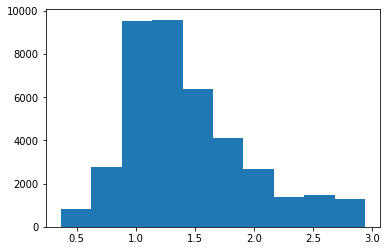

In [194]:
gaussprobs = gmm.predict_proba(points)
clusterscores = model.transform(gaussprobs)
plt.hist(clusterscores.sum(axis=1))

In [120]:
#plt.scatter(range(len(clusterscores[0])),clusterscores.sum(axis=1))
#plt.show()
#plt.hist(clusterscores.sum(axis=1))
#model.components_.sum(axis=1)
"""PageRank algorithm with explicit number of iterations.

Returns
-------
ranking of nodes (pages) in the adjacency matrix

"""

import numpy as np

def pagerank(M, num_iterations: int = 100, d: float = 0.85):
    """PageRank: The trillion dollar algorithm.

    Parameters
    ----------
    M : numpy array
        adjacency matrix where M_i,j represents the link from 'j' to 'i', such that for all 'j'
        sum(i, M_i,j) = 1
    num_iterations : int, optional
        number of iterations, by default 100
    d : float, optional
        damping factor, by default 0.85

    Returns
    -------
    numpy array
        a vector of ranks such that v_i is the i-th rank from [0, 1],
        v sums to 1

    """
    N = M.shape[1]
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    for i in range(num_iterations):
        v = d * M @ v + (1 - d) / N
    return v


M = np.array([[0.25, 0, 0, 0, 1],
              [0.25, 0, 0, 0, 0],
              [0.5, 0, 0, 0, 0],
              [0, 1, 0.5, 0, 0],
              [0, 0, 0.5, 1, 0]])
v = pagerank(M, 100, 0.85)
v

array([[0.31007717],
       [0.0958914 ],
       [0.1617828 ],
       [0.18026538],
       [0.25198326]])